In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Dropout
#from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import time
from scipy.signal import find_peaks



## Raw training validation

484
0.7166666666666667
395
0.9850746268656716


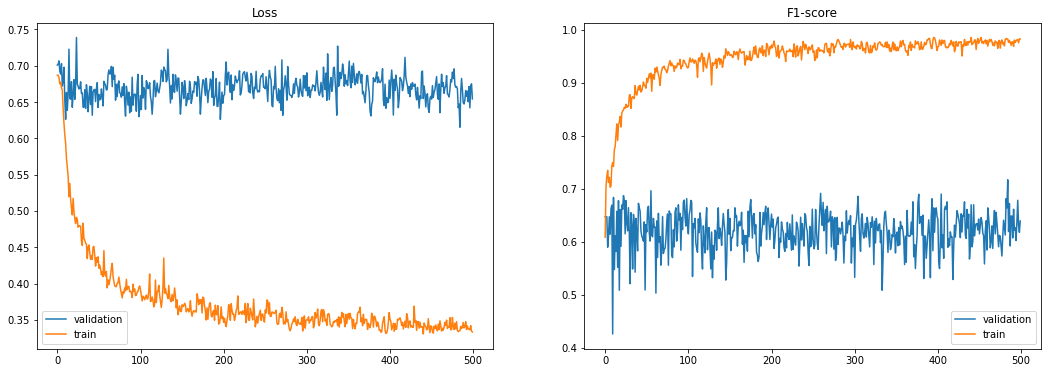

In [2]:
pth = glob.glob("/Users/jiayihan/Documents/testtest/*raw*.pkl")
a_file = open(pth[0], "rb")
foldperf= pickle.load(a_file)
fig=plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(foldperf['test_loss'])
plt.plot(foldperf['train_loss'])
plt.title('Loss')
plt.legend(['validation','train'])
plt.subplot(1,2,2)
plt.plot(foldperf['test_f1'])
plt.plot(foldperf['train_f1'])
plt.title('F1-score')
plt.legend(['validation','train'])
print(np.argmax(foldperf['test_f1']))
print(np.max(foldperf['test_f1']))
print(np.argmax(foldperf['train_f1']))
print(np.max(foldperf['train_f1']))

## Frequency training validation 

467
0.7101449275362319
469
0.7672413793103449


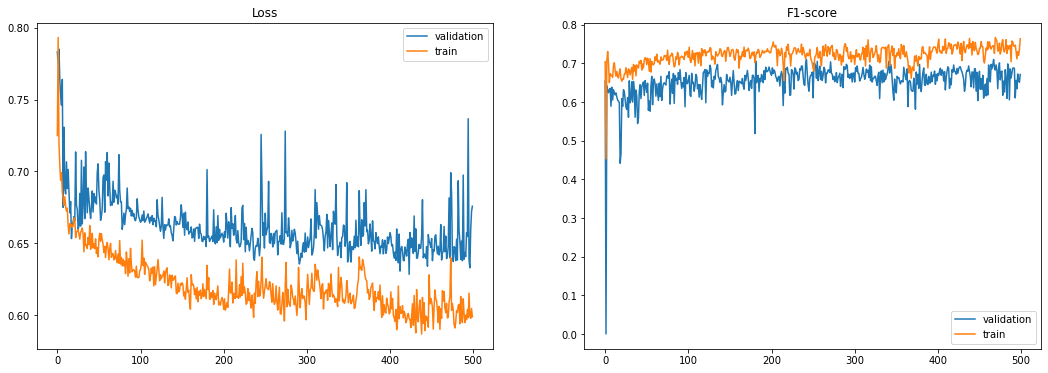

In [3]:
pth = glob.glob("/Users/jiayihan/Documents/testtest/*freq*.pkl")
a_file = open(pth[0], "rb")
foldperf= pickle.load(a_file)
fig=plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(foldperf['test_loss'])
plt.plot(foldperf['train_loss'])
plt.title('Loss')
plt.legend(['validation','train'])
plt.subplot(1,2,2)
plt.plot(foldperf['test_f1'])
plt.plot(foldperf['train_f1'])
plt.title('F1-score')
plt.legend(['validation','train'])
print(np.argmax(foldperf['test_f1']))
print(np.max(foldperf['test_f1']))
print(np.argmax(foldperf['train_f1']))
print(np.max(foldperf['train_f1']))

# Import the model for frequency data 

In [4]:
## Define dataloader for the test data
class ParkinsonsDataset(Dataset):
    def __init__(self):
        pathLabels = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/test_labels2.csv'
        self.pathFiles = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/freq_domain'
        self.y = pd.read_csv(pathLabels)
        self.label = self.y['filenames']
    def __len__(self):
        return len(self.label)
    def __getitem__(self, index):
        tempath = self.y.iloc[index]['filenames']
        signalpath = os.path.join(self.pathFiles,'freq_'+tempath)
        self.x = torch.from_numpy(np.load(signalpath).astype(np.double))
        return self.x, self.y.iloc[index]['binary']

In [10]:
# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.L = 16
        self.K = 1
        self.M = 64
        ## feature extraction
        self.featureExtract = nn.Sequential(nn.Linear(76,256),
                                            nn.LeakyReLU(negative_slope=0.2),
                                            Dropout(p = 0.5, inplace = False),
                                            nn.Linear(256,128),
                                            nn.LeakyReLU(negative_slope=0.2),
                                            Dropout(p = 0.5, inplace = False),
                                            nn.Linear(128,self.M))

        self.attention = nn.Sequential(nn.Linear(self.M, self.L),
                                       nn.Tanh(),
                                       nn.Linear(self.L, self.K))

        self.classify = nn.Sequential(nn.Linear(self.M,32),
                                      nn.LeakyReLU(negative_slope=0.2),
                                      Dropout(p = 0.1, inplace = False),
                                      nn.Linear(32,16),
                                      nn.LeakyReLU(negative_slope=0.2),
                                      Dropout(p = 0.4, inplace = False),
                                      nn.Linear(16,2),
                                      nn.Softmax(dim = 1))
    def forward(self, x):
        ## feature extraction

        H = self.featureExtract(x)

        A = self.attention(H)
        A = torch.transpose(A,1,0)
        s = nn.Softmax(dim=1)
        A = s(A)

        z = torch.mm(A,H)

        output = self.classify(z)
        Y_prob , Y_hat = torch.max(output,dim=1)

        return Y_prob, Y_hat, A, output


In [11]:
PATH = '/Users/jiayihan/Documents/testtest/epoch467.pt'
model = torch.load(PATH,map_location=torch.device('cpu'))
model.eval()

Net(
  (featureExtract): Sequential(
    (0): Linear(in_features=76, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (attention): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
  (classify): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
    (7): Softmax(dim=1)
  )
)

In [12]:
pd_data_test = ParkinsonsDataset()
test_loader = DataLoader(dataset = pd_data_test,  batch_size = 1)

In [13]:
test_loss_ = 0.
predicted = []
true = []
Attention = []
loss_fn =  nn.CrossEntropyLoss();
tic = time.perf_counter()


for i, (data, bag_label) in enumerate(test_loader):
    data, bag_label = Variable(data), Variable(bag_label)
    data, bag_label = data.type(torch.float), bag_label.type(torch.float)
    data = torch.squeeze(data)

    Y_prob, Y_hat, A, output = model(data)
    
    predicted.append(Y_hat.detach().cpu().numpy())
    
    true.append(bag_label.detach().cpu().numpy())
    
    Attention.append(A)
    
    loss = loss_fn(output.cpu(),bag_label.cpu().type(torch.LongTensor))
    test_loss_ += loss.item()
toc = time.perf_counter()
test_loss =test_loss_ / len(test_loader)
f1score = f1_score(true, predicted)
print('Results:')
print('----------------------------------------------------')
print('Test f1 score',f1score)
print('Test loss on frequency data',test_loss)
print('----------------------------------------------------')
print(f"Evaluation time {toc - tic:0.4f} seconds")

Results:
----------------------------------------------------
Test f1 score 0.6944444444444444
Test loss on frequency data 0.6475985467433929
----------------------------------------------------
Evaluation time 0.1812 seconds


### Evaluation of the attention and what kind of assignments there's been on various examples

## Raw results

In [14]:
class ParkinsonsDatasetRaw(Dataset):
    def __init__(self):
        pathLabels = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/test_labels2.csv'
        self.pathFiles = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/stdnorm'
        self.y = pd.read_csv(pathLabels)
        self.label = self.y['filenames']
    def __len__(self):
        return len(self.label)
    def __getitem__(self, index):
        tempath = self.y.iloc[index]['filenames']
        signalpath = os.path.join(self.pathFiles,tempath)
        self.x = torch.from_numpy(np.load(signalpath).astype(np.double))
        return self.x, self.y.iloc[index]['binary']

In [15]:
PATH = '/Users/jiayihan/Documents/testtest/epoch484.pt'
modelraw = torch.load(PATH,map_location=torch.device('cpu'))
modelraw.eval()

Net(
  (featureExtract): Sequential(
    (0): Conv1d(12, 32, kernel_size=(8,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv1d(32, 32, kernel_size=(8,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv1d(32, 16, kernel_size=(16,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.1, inplace=Fals

In [16]:
test_loss_ = 0.
test_acc_ = 0.
predicted=[]
true=[]
Attention =[]
pd_data_test = ParkinsonsDatasetRaw()
test_loader = DataLoader(dataset = pd_data_test,  batch_size = 1)
tic = time.perf_counter()
for i, (data, bag_label) in enumerate(test_loader):

    data, bag_label = data.type(torch.float), bag_label.type(torch.float)

    data, bag_label = Variable(data), Variable(bag_label)
    data = torch.swapaxes(data,3,2)
    data = torch.squeeze(data)
    Y_prob, Y_hat, A, output = modelraw(data)
    predicted.append(Y_hat.detach().cpu().numpy())
    true.append(bag_label.detach().cpu().numpy())
    Attention.append(A)
    loss = loss_fn(output.cpu(),bag_label.cpu().type(torch.LongTensor))
    test_loss_ += loss.item()
toc = time.perf_counter()
#test_acc =test_acc_ / len(test_loader)
test_loss =test_loss_ / len(test_loader)
f1score = f1_score(true, predicted)
print('Results:')
print('----------------------------------------------------')
print('Test f1 score',f1score)
print('Test loss on frequency data',test_loss)
print('----------------------------------------------------')
print(f"Evaluation time {toc - tic:0.4f} seconds")

Results:
----------------------------------------------------
Test f1 score 0.6571428571428571
Test loss on frequency data 0.712936211625735
----------------------------------------------------
Evaluation time 5.6076 seconds


In [17]:
def testModelRaw(data):
    data = data.type(torch.float)
    data = Variable(data)
    data = torch.swapaxes(data,2,1)
    data = torch.squeeze(data)
    Y_prob, Y_hat, A, output = modelraw(data)
    return Y_prob, Y_hat, A, output

In [18]:
def testModelfreq(data):
    data = Variable(data)
    data  = data.type(torch.float)
    Y_prob, Y_hat, A, output = model(data)
    return Y_prob, Y_hat, A, output 

## Test pr ID 

In [20]:
pathsTest = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/test_labels2.csv'
pathTestFiles='/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/stdnorm'
pathTestFilesFreq='/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/freq_domain'
DataTest =  pd.read_csv(pathsTest)

In [40]:
DataTest.iloc[0]['filenames'][-10:-4]

'110003'

In [47]:
PDid = []
yhatRaw = [] 
yhatFreq = []

for fIDx in range(DataTest.shape[0]):
    filename = DataTest.iloc[fIDx]['filenames']
    
    PDid.append(filename[-10:-4])
    
    freqData = torch.from_numpy(np.load(os.path.join(pathTestFilesFreq,'freq_'+filename)).astype(np.float32))
    rawData = torch.from_numpy(np.load(os.path.join(pathTestFiles,filename)).astype(np.float32))
    
    _, Y_hat, A, _ = testModelRaw(rawData)
    _, Y_hat_freq, A_freq, _ = testModelfreq(freqData)
    
    yhatRaw.append(int(Y_hat))
    yhatFreq.append(int(Y_hat_freq))


In [88]:
dfID = pd.DataFrame(np.transpose([np.array(PDid), np.array(yhatRaw),np.array(yhatFreq)]), columns=['ID','Raw', 'Freq'])

In [92]:
dfID=dfID.astype({'Raw': 'int32'})
dfID=dfID.astype({'Freq': 'int32'})
CrossDF_raw = pd.crosstab(dfID['ID'], dfID['Raw'],
           values=dfID['Raw'], aggfunc='count')
CrossDF_freq = pd.crosstab(dfID['ID'], dfID['Freq'],
           values=dfID['Freq'], aggfunc='count')


In [113]:
CrossDFGT= pd.crosstab(dfID['ID'], DataTest['binary'],
           values=DataTest['binary'], aggfunc='count' )

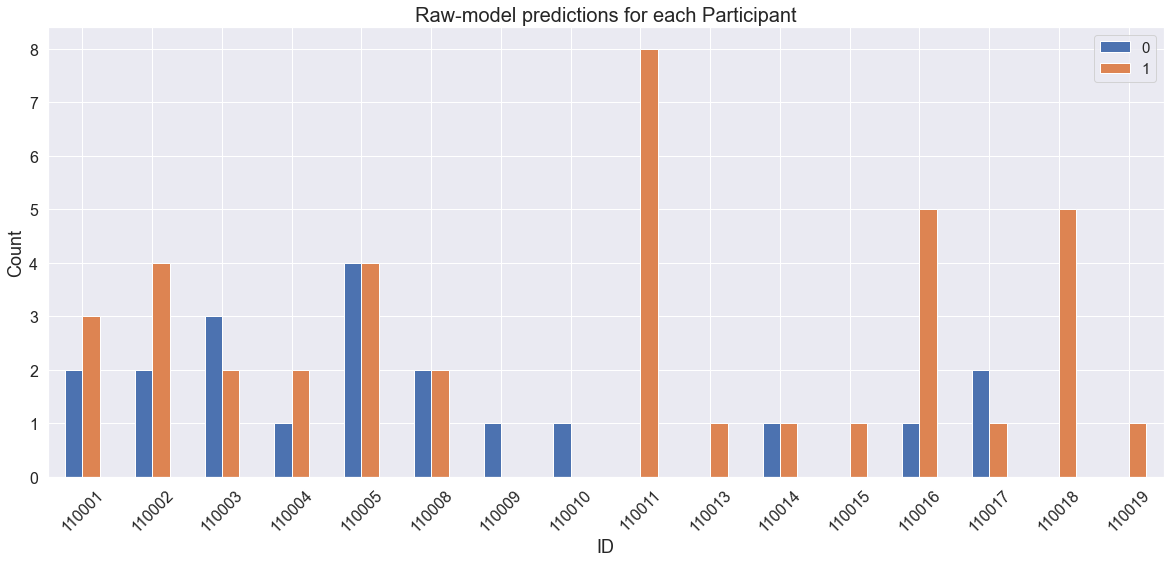

In [115]:
ax0 = CrossDF_raw.plot.bar(rot=45,fontsize=16,title='Raw-model predictions for each Participant')
ax0.title.set_size(20)
ax0.set_xlabel("ID",fontsize=18)
ax0.set_ylabel("Count",fontsize=18)
ax0.legend(fontsize = 15)
plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/RAW_ID.png')

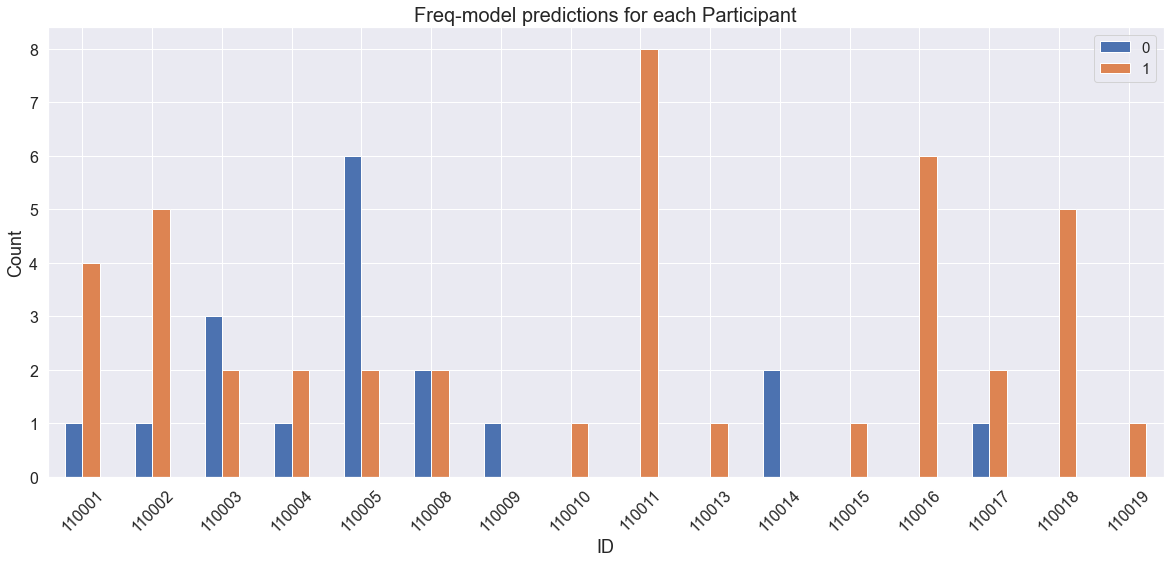

In [116]:
ax = CrossDF_freq.plot.bar(rot=45,title='Freq-model predictions for each Participant',fontsize=16)
ax.title.set_size(20)
ax.set_xlabel("ID",fontsize=18)
ax.set_ylabel("Count",fontsize=18)
ax.legend(fontsize = 15)
plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/FREQ_ID.png')

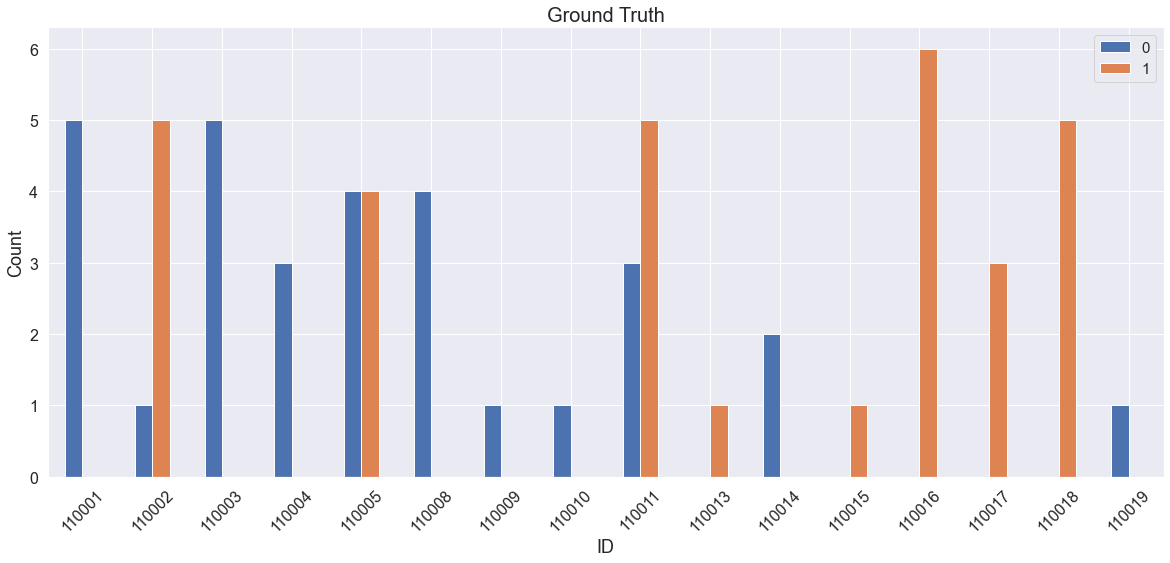

In [117]:
ax = CrossDFGT.plot.bar(rot=45,title='Ground Truth',fontsize=16)
ax.title.set_size(20)
ax.set_xlabel("ID",fontsize=18)
ax.set_ylabel("Count",fontsize=18)
ax.legend(fontsize = 15)
plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/GT_ID.png')



# Evaluation of the attention and what kind of assignments there's been on various examples

Noter : 
- Index 24 looks like outlier data 
- 

In [448]:
def plotEverything(data,A,A_freq): 
    fig = plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    plt.plot(time2,torch.reshape(data[:,:,0],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,1],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,2],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,3],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,4],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,5],(-1,)))

    plt.axvline(x=torch.argmin(A)*5,color='r')
    plt.axvline(x=torch.argmin(A)*5-5,color='r')
    plt.axvline(x=torch.argmax(A)*5) 
    plt.axvline(x=torch.argmax(A)*5-5)
    plt.title('Right side',fontsize=20)
    plt.xlabel('Time (sec)',fontsize=15)
    plt.ylabel('Amplitude',fontsize=15)
    plt.legend(['A_x','A_y','A_z','G_x','G_y','G_z'])


    #plt.axvline(x=torch.argmin(A_freq)*5,color='r')
    #plt.axvline(x=torch.argmin(A_freq)*5-5,color='r')
    #plt.axvline(x=torch.argmax(A_freq)*5,color='r') 
    #plt.axvline(x=torch.argmax(A_freq)*5-5,color='r')

    plt.subplot(2,1,2)
    
    plt.plot(time2,torch.reshape(data[:,:,6],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,7],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,8],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,9],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,10],(-1,)))
    plt.plot(time2,torch.reshape(data[:,:,11],(-1,)))
    
    plt.axvline(x=torch.argmin(A)*5,color='r')
    plt.axvline(x=torch.argmin(A)*5-5,color='r')
    plt.axvline(x=torch.argmax(A)*5) 
    plt.axvline(x=torch.argmax(A)*5-5)
    plt.title('Left side',fontsize=20)
    plt.xlabel('Time (sec)',fontsize=15)
    plt.ylabel('Amplitude',fontsize=15)
    plt.legend(['A_x','A_y','A_z','G_x','G_y','G_z'])
    #plt.axvline(x=torch.argmin(A_freq)*5,color='r')
    #plt.axvline(x=torch.argmin(A_freq)*5-5,color='r')
    #plt.axvline(x=torch.argmax(A_freq)*5,color='r') 
    #plt.axvline(x=torch.argmax(A_freq)*5-5,color='r')

In [442]:
def AttentionedData(data,A):
    time = np.linspace(0, 5, 500, endpoint=True)


    fig = plt.figure(figsize=(20,15))
    plt.subplot(2,2,1)
    plt.title('Largest Attention (right side). Attention:'+  str("{0:.5f}".format((torch.max(A).item()))),fontsize=20)


    plt.plot(time,data[torch.argmax(A),:,0])
    plt.plot(time,data[torch.argmax(A),:,1]) 
    plt.plot(time,data[torch.argmax(A),:,2])
    plt.plot(time,data[torch.argmax(A),:,3])
    plt.plot(time,data[torch.argmax(A),:,4]) 
    plt.plot(time,data[torch.argmax(A),:,5])
    plt.xlabel('Time (sec)',fontsize=15)
    plt.ylabel('Amplitude',fontsize=15)
    plt.legend(['A_x','A_y','A_z','G_x','G_y','G_z'])


    plt.subplot(2,2,3)
    
    plt.title('Largest Attention (left side). Attention:'+  str("{0:.5f}".format((torch.max(A).item()))),fontsize=20)


    plt.plot(time,data[torch.argmax(A),:,6])
    plt.plot(time,data[torch.argmax(A),:,7]) 
    plt.plot(time,data[torch.argmax(A),:,8])
    plt.plot(time,data[torch.argmax(A),:,9])
    plt.plot(time,data[torch.argmax(A),:,10]) 
    plt.plot(time,data[torch.argmax(A),:,11])
    plt.xlabel('Time (sec)',fontsize=15)
    plt.ylabel('Amplitude',fontsize=15)
    plt.legend(['A_x','A_y','A_z','G_x','G_y','G_z'])


    plt.subplot(2,2,2)
    
    

    plt.title('Smallest Attention (right side). Attention:'+  str("{0:.5f}".format((torch.min(A).item()))),fontsize=20)
    plt.plot(time,data[torch.argmin(A),:,0])
    plt.plot(time,data[torch.argmin(A),:,1]) 
    plt.plot(time,data[torch.argmin(A),:,2])
    plt.plot(time,data[torch.argmin(A),:,3])
    plt.plot(time,data[torch.argmin(A),:,4]) 
    plt.plot(time,data[torch.argmin(A),:,5])
    plt.xlabel('Time (sec)',fontsize=15)
    plt.ylabel('Amplitude',fontsize=15)
    plt.legend(['A_x','A_y','A_z','G_x','G_y','G_z'])


    plt.subplot(2,2,4)
    plt.title('Smallest Attention (left side). Attention:'+  str("{0:.5f}".format((torch.min(A).item()))),fontsize=20)
    plt.plot(time,data[torch.argmin(A),:,6])
    plt.plot(time,data[torch.argmin(A),:,7]) 
    plt.plot(time,data[torch.argmin(A),:,8])
    plt.plot(time,data[torch.argmin(A),:,9])
    plt.plot(time,data[torch.argmin(A),:,10]) 
    plt.plot(time,data[torch.argmin(A),:,11])
    plt.xlabel('Time (sec)',fontsize=15)
    plt.ylabel('Amplitude',fontsize=15)
    plt.legend(['A_x','A_y','A_z','G_x','G_y','G_z'])



In [535]:
def AttentionedDataFreq(data,A):
    time2 = np.linspace(0, 25, 76, endpoint=True)



    fig = plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    
    peaksmax, _ = find_peaks(data[torch.argmax(A),:], distance = 75)
    
    plt.plot(time2,data[torch.argmax(A),:])
    plt.plot(time2[peaksmax], data[torch.argmax(A),:][peaksmax], "x")
    plt.ylabel( r'Power spectral density $(V^2 / Hz)$' ,fontsize = 15)

    print(time2[peaksmax])
    plt.title('Largest Attention', fontsize=20)
    plt.xlabel('Frequency (Hz)',fontsize = 15)

    plt.subplot(1,2,2)
    plt.title('Smallest Attention', fontsize =20)
    
    peaks, _ = find_peaks(data[torch.argmin(A),:], distance = 75)
    
    plt.plot(time2,data[torch.argmin(A),:])

    plt.plot(time2[peaks], data[torch.argmin(A),:][peaks], "x")
    print(time2[peaks])
    plt.ylabel( r'Power spectral density $(V^2 / Hz)$' ,fontsize = 15)
    
    plt.xlabel('Frequency (Hz)', fontsize = 15)

In [473]:
AttentionFreq = []
AttentionRaw = [] 
Labels = np.zeros((DataTest.shape[0],3))
for fIDx in range(DataTest.shape[0]):
    
    filename = DataTest.iloc[fIDx]['filenames']
    
    freqData = torch.from_numpy(np.load(os.path.join(pathTestFilesFreq,'freq_'+filename)).astype(np.float32))
    rawData = torch.from_numpy(np.load(os.path.join(pathTestFiles,filename)).astype(np.float32))

    _, Y_hat, A, _ = testModelRaw(rawData)
    _, Y_hat_freq, A_freq, _ = testModelfreq(freqData)
    
    AttentionFreq.append(A_freq)
    Attention.append(A)
    
    Labels[fIDx,0]= DataTest.iloc[fIDx]['binary']
    Labels[fIDx,1]= Y_hat
    Labels[fIDx,2]= Y_hat_freq



In [474]:
df = pd.DataFrame(Labels, columns = ['GroundTruth','Raw','Freq'])

In [708]:
print(df[(df['GroundTruth']==0) & (df['Raw']==1)].shape)
print(df[(df['GroundTruth']==0) & (df['Raw']==0)].shape)
print(df[(df['GroundTruth']==1) & (df['Raw']==0)].shape)
print(df[(df['GroundTruth']==1) & (df['Raw']==1)].shape)

(17, 5)
(13, 5)
(7, 5)
(23, 5)


In [709]:
print(df[(df['GroundTruth']==0) & (df['Freq']==1)].shape)
print(df[(df['GroundTruth']==0) & (df['Freq']==0)].shape)
print(df[(df['GroundTruth']==1) & (df['Freq']==0)].shape)
print(df[(df['GroundTruth']==1) & (df['Freq']==1)].shape)

(17, 5)
(13, 5)
(5, 5)
(25, 5)


In [554]:
pathsTest = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/test_labels2.csv'
pathTestFiles='/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/stdnorm'
pathTestFilesFreq='/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/freq_domain'
DataTest =  pd.read_csv(pathsTest)
id1 = 17
id2 = 33
id3 = 33
id4 = 56
id5 = 5


test1 = DataTest.iloc[id1]['filenames']
test2 = DataTest.iloc[id2]['filenames']
test3 = DataTest.iloc[id3]['filenames']
test4 = DataTest.iloc[id4]['filenames']
test5 = DataTest.iloc[id5]['filenames']



print('Ground truth test data 1:', DataTest.iloc[id1]['binary'] )
print('Ground truth test data 2:', DataTest.iloc[id2]['binary'] )
print('Ground truth test data 3:', DataTest.iloc[id3]['binary'] )
print('Ground truth test data 4:', DataTest.iloc[id4]['binary'] )
print('Ground truth test data 4:', DataTest.iloc[id5]['binary'] )



Example_data_1 = torch.from_numpy(np.load(os.path.join(pathTestFiles,test1)).astype(np.float32))
Example_data_2 = torch.from_numpy(np.load(os.path.join(pathTestFiles,test2)).astype(np.float32))
Example_data_3 = torch.from_numpy(np.load(os.path.join(pathTestFiles,test3)).astype(np.float32))
Example_data_4 = torch.from_numpy(np.load(os.path.join(pathTestFiles,test4)).astype(np.float32))
Example_data_5 = torch.from_numpy(np.load(os.path.join(pathTestFiles,test5)).astype(np.float32))



Example_data_1_freq = torch.from_numpy(np.load(os.path.join(pathTestFilesFreq,'freq_'+test1)).astype(np.float32))
Example_data_2_freq = torch.from_numpy(np.load(os.path.join(pathTestFilesFreq,'freq_'+test2)).astype(np.float32))
Example_data_3_freq = torch.from_numpy(np.load(os.path.join(pathTestFilesFreq,'freq_'+test3)).astype(np.float32))
Example_data_4_freq = torch.from_numpy(np.load(os.path.join(pathTestFilesFreq,'freq_'+test4)).astype(np.float32))
Example_data_5_freq = torch.from_numpy(np.load(os.path.join(pathTestFilesFreq,'freq_'+test5)).astype(np.float32))

print('Raw data')
print('------------------------------------------')
_, Y_hat_1, A_1, _ = testModelRaw(Example_data_1)
_, Y_hat_2, A_2, _ = testModelRaw(Example_data_2)
_, Y_hat_3, A_3, _ = testModelRaw(Example_data_3)
_, Y_hat_4, A_4, _ = testModelRaw(Example_data_4)
_, Y_hat_5, A_5, _ = testModelRaw(Example_data_5)
print('Predicted for test data 1:', Y_hat_1)
print('Predicted for test data 2:', Y_hat_2)
print('Predicted for test data 3:', Y_hat_3)
print('Predicted for test data 4:', Y_hat_4)
print('Predicted for test data 5:', Y_hat_5)

print('------------------------------------------')

print('Frequency data')
print('------------------------------------------')

_, Y_hat_1_freq, A_1_freq, _ = testModelfreq(Example_data_1_freq)
_, Y_hat_2_freq, A_2_freq, _ = testModelfreq(Example_data_2_freq)
_, Y_hat_3_freq, A_3_freq, _ = testModelfreq(Example_data_3_freq)
_, Y_hat_5_freq, A_5_freq, _ = testModelfreq(Example_data_5_freq)


print('Predicted for test data 1:', Y_hat_1_freq)
print('Predicted for test data 2:', Y_hat_2_freq)
print('Predicted for test data 3:', Y_hat_3_freq)
print('Predicted for test data 4:', Y_hat_4_freq)
print('Predicted for test data 5:', Y_hat_5_freq)
print('------------------------------------------')

Ground truth test data 1: 1
Ground truth test data 2: 0
Ground truth test data 3: 0
Ground truth test data 4: 0
Ground truth test data 4: 0
Raw data
------------------------------------------
Predicted for test data 1: tensor([1])
Predicted for test data 2: tensor([1])
Predicted for test data 3: tensor([1])
Predicted for test data 4: tensor([0])
Predicted for test data 5: tensor([0])
------------------------------------------
Frequency data
------------------------------------------
Predicted for test data 1: tensor([1])
Predicted for test data 2: tensor([1])
Predicted for test data 3: tensor([1])
Predicted for test data 4: tensor([0])
Predicted for test data 5: tensor([1])
------------------------------------------


In [ ]:
DataTest.iloc[33]

In [734]:
torch.max(A_2)

tensor(0.1131, grad_fn=<MaxBackward1>)

[6.33333333]
[0.66666667]


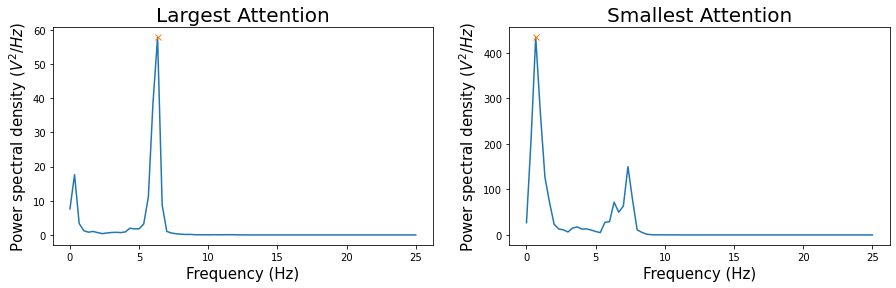

In [738]:
AttentionedDataFreq(Example_data_2_freq,A_2_freq)

In [552]:
#AttentionedData(Example_data_1,A_1)
#plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/both_correct.png')

In [550]:
#plotEverything(Example_data_1,A_1,A_1_freq)
#plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/Overview_bothCorrect.png')

In [551]:
#AttentionedDataFreq(Example_data_1_freq,A_1)
#plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/bothCorrectFreq_.png',pad_inches = 0)

[6.33333333]
[0.66666667]
[5.]
[0.66666667]


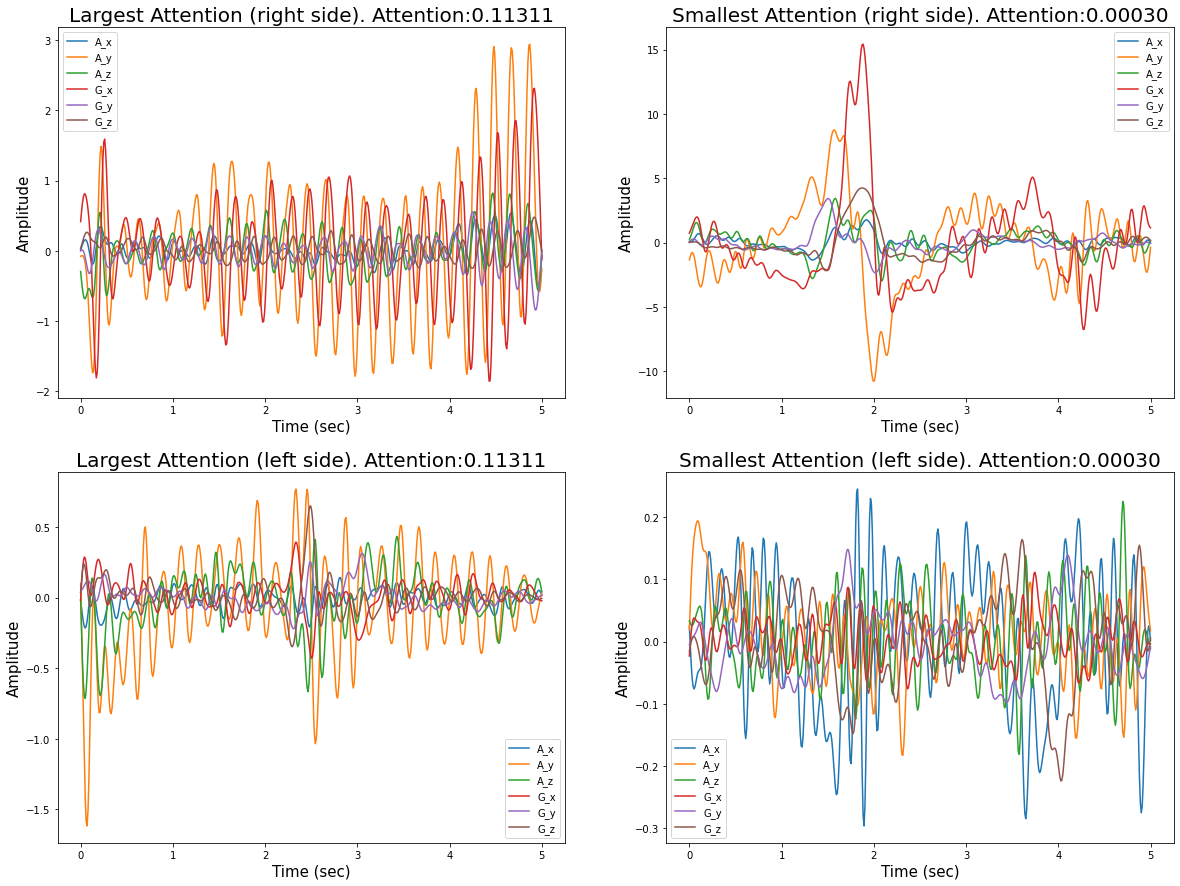

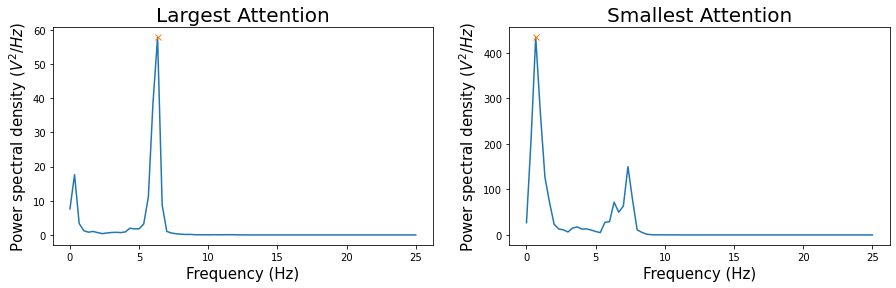

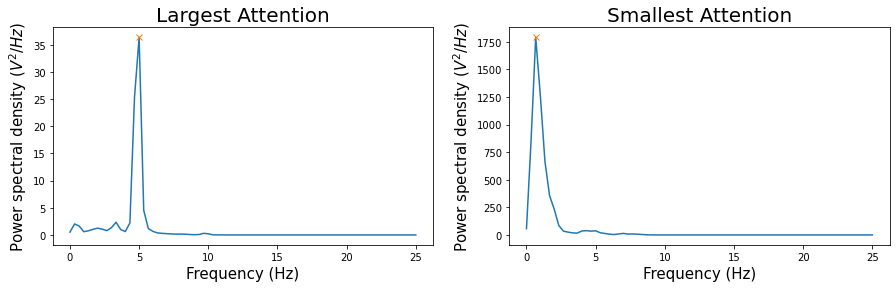

In [556]:
#plotEverything(Example_data_3,A_3,A_3_freq)
AttentionedData(Example_data_3,A_3)
plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/bothwrong_time.png')
AttentionedDataFreq(Example_data_3_freq,A_3_freq)
plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/bothwrong_freq.png')

AttentionedDataFreq(Example_data_3_freq,A_3)
plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/bothwrong_freqR.png')



## Dominant frequency in the largest attention and predictions scatterplot

In [561]:
## with the raw model
## with the freq model

DomFRaw = []
DomFFreq = []

time2 = np.linspace(0, 25, 76, endpoint=True)

for fIDx in range(DataTest.shape[0]):
    filename = DataTest.iloc[fIDx]['filenames']
    
    freqData = torch.from_numpy(np.load(os.path.join(pathTestFilesFreq,'freq_'+filename)).astype(np.float32))
    rawData = torch.from_numpy(np.load(os.path.join(pathTestFiles,filename)).astype(np.float32))
    
    _, Y_hat, A, _ = testModelRaw(rawData)
    _, Y_hat_freq, A_freq, _ = testModelfreq(freqData)
    
    peaksFreq, _ = find_peaks(freqData[torch.argmax(A_freq),:], distance = 75)
    peaksRaw, _ = find_peaks(freqData[torch.argmax(A),:], distance = 75)
    
    DomFRaw.append(time2[peaksRaw]) 
    DomFFreq.append(time2[peaksFreq])
    
df['FreqDomF']=np.array(DomFFreq)
df['RawDomF']=np.array(DomFRaw)    

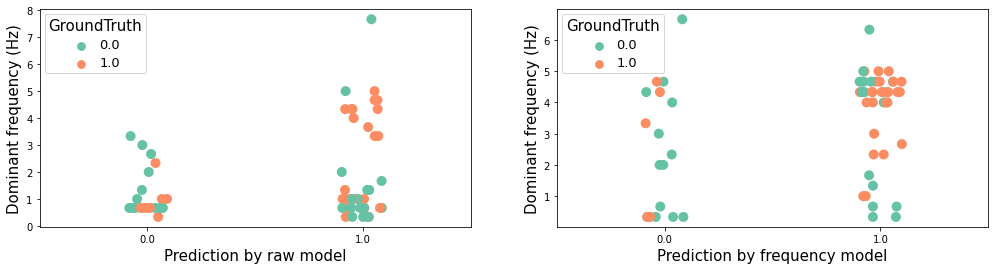

In [805]:
fig = plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
ax = sns.stripplot(x="Raw", y="RawDomF", hue="GroundTruth", data=df,size=10, palette="Set2")
ax.set_ylabel('Dominant frequency (Hz)',fontsize = 15)
ax.set_xlabel('Prediction by raw model',fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.subplot(1,2,2)
ax = sns.stripplot(x="Freq", y="FreqDomF", hue="GroundTruth", data=df, size=10, palette="Set2")
ax.set_ylabel('Dominant frequency (Hz)',fontsize = 15)
ax.set_xlabel('Prediction by frequency model',fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/freqOverview.png')



## Generate Table for paragit data 

In [652]:
path_paragit = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/ParagitDataStd/*'

In [653]:
path_paragitFreq = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/paragitFreq/*'

In [654]:
PathsRaw = glob.glob(path_paragit) #[0][102:]
PathsFreq =  glob.glob(path_paragitFreq) #[0][99:]

In [655]:
filename = 1
abbriv = 1
filenameslist = []
filenameslistfreq = []
for files in range(len(PathsRaw)):
    filenameslist.append(str(abbriv)+'_'+str(filename)+'.npy')
    filenameslistfreq.append('freq_'+str(abbriv)+'_'+str(filename)+'.npy')
    # name updates
    filename += 1
    if (files+1)% 4 == 0:
        filename = 1
        abbriv += 1

### Paragit data with raw data

In [656]:
pathFiles = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/ParagitDataStd/'
predictedRaw = []
for filenames in filenameslist:
    signalpath = os.path.join(pathFiles,filenames)
    datax = torch.from_numpy(np.load(signalpath).astype(np.float32))
    datax.type(torch.float)
    datax = Variable(datax)
    datax = torch.swapaxes(datax,2,1)
    Y_prob, Y_hat, A, output = modelraw(datax)
    predictedRaw.append(Y_hat)

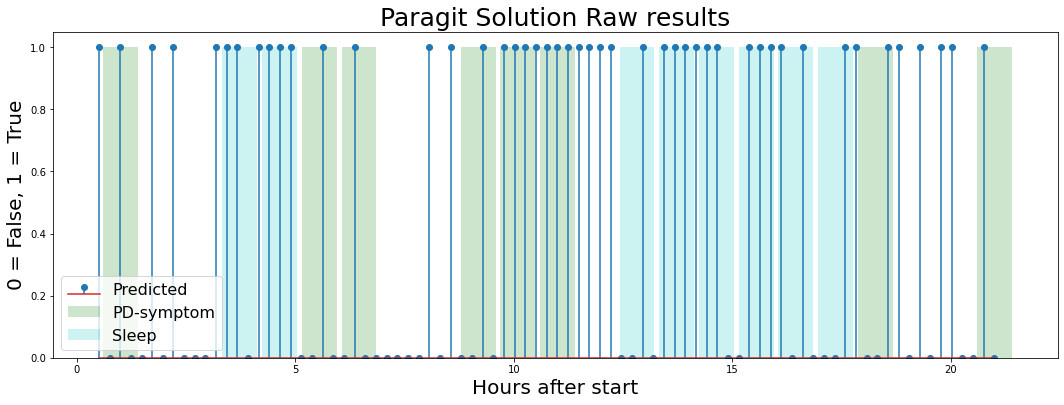

In [665]:
bnfig=plt.figure(figsize=(18,6))
x = np.linspace(0.5,21,85)
groundtruth =[1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1]
sleep =[0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0]
xg = np.linspace(1,21,23)
plt.stem(x,predictedRaw)
plt.bar(xg,groundtruth, alpha=0.2, color = 'g')
plt.bar(xg,sleep, alpha=0.2, color = 'c')
plt.title('Paragit Solution Raw results',fontsize=25)
plt.xlabel('Hours after start',fontsize=20)
plt.ylabel('0 = False, 1 = True',fontsize=20)
plt.legend(['Predicted','PD-symptom','Sleep'],fontsize=16)
fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/ParagitRaw.png')

In [700]:
datax_para = torch.from_numpy(np.load(os.path.join(pathFiles,filenameslist[10])).astype(np.float32))
Y_prob_p, Y_hat_p, A_p, output_p = testModelRaw(datax_para)

In [701]:
Y_hat_p

tensor([0])

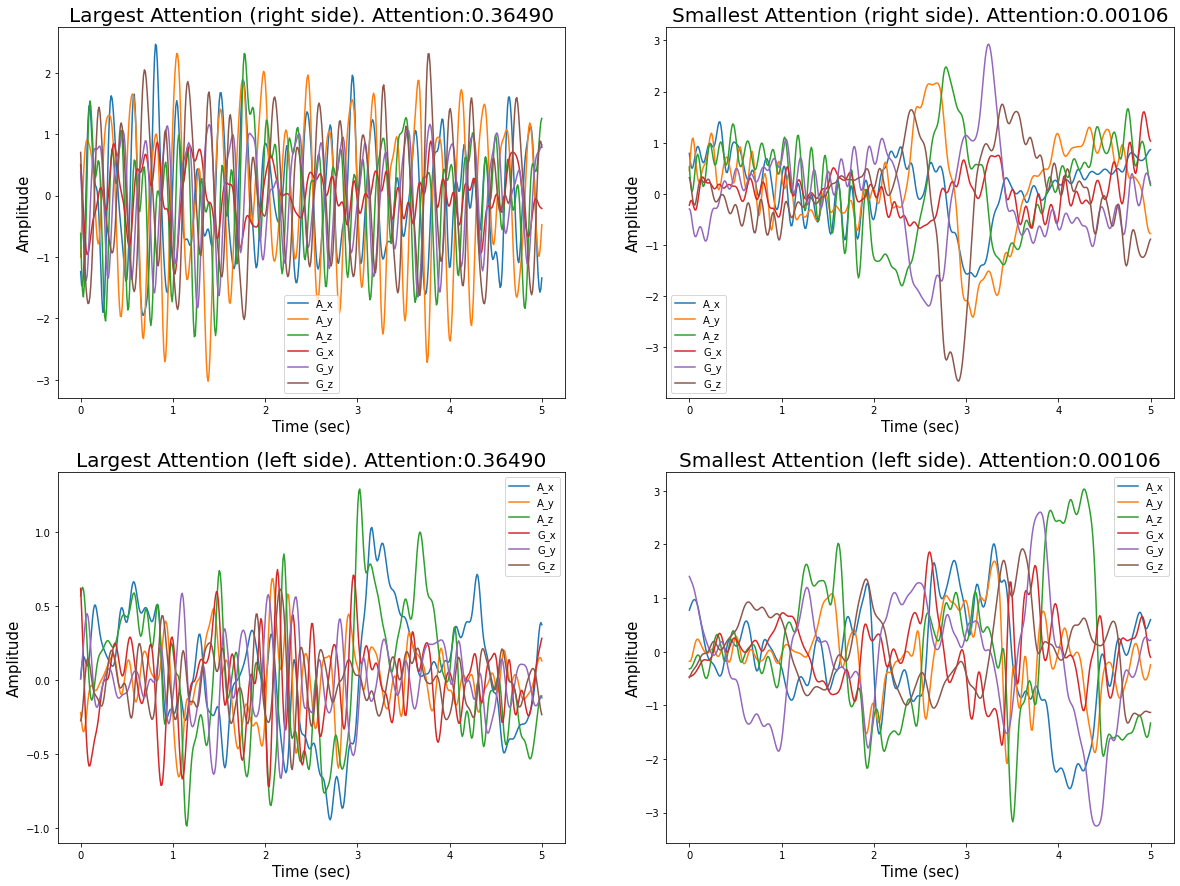

In [702]:
AttentionedData(datax_para,A_p)
#plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/0th_para1.png')

 ### Paragit data with frequency data

In [808]:
path_paragitFreq = '/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/paragitFreq/'
predictedfreq = []
for filenames in filenameslistfreq:
    signalpath = os.path.join(path_paragitFreq,filenames)
    datax = torch.from_numpy(np.load(signalpath).astype(np.float32))
    datax.type(torch.float)
    datax = Variable(datax)
    Y_prob, Y_hat, A, output = model(datax)
    predictedfreq.append(Y_hat)

In [812]:
predictedfreq

[tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tenso

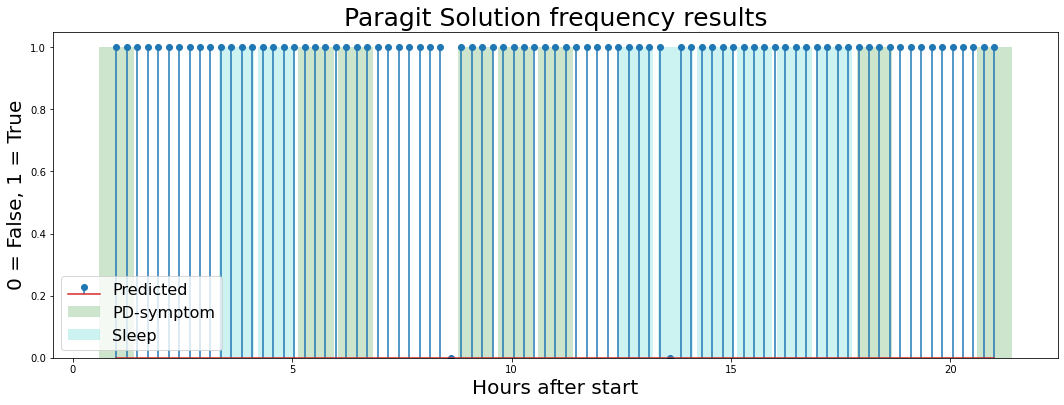

In [809]:
bnfig=plt.figure(figsize=(18,6))
x = np.linspace(1,21,85)
groundtruth =[1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1]
sleep =[0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0]
xg = np.linspace(1,21,23)
plt.stem(x,predictedfreq)
plt.bar(xg,groundtruth, alpha=0.2, color = 'g')
plt.bar(xg,sleep, alpha=0.2, color = 'c')
plt.title('Paragit Solution frequency results',fontsize=25)
plt.xlabel('Hours after start',fontsize=20)
plt.ylabel('0 = False, 1 = True',fontsize=20)
plt.legend(['Predicted','PD-symptom','Sleep'],fontsize=16)
fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/ParagitFreq.png')

In [813]:
## with the raw model
## with the freq model

DomFRawPara = []
DomFFreqPara = []
yhatFreq = []
yhatRaw = []
time2 = np.linspace(0, 25, 76, endpoint=True)

for filenames in filenameslist:
    
    signalpath = os.path.join(path_paragitFreq,filenames)
    
    freqDataPara = torch.from_numpy(np.load(os.path.join(path_paragitFreq,'freq_'+filenames)).astype(np.float32))
    rawDataPara = torch.from_numpy(np.load(os.path.join(pathFiles,filenames)).astype(np.float32))
    
    _, Y_hat, A, _ = testModelRaw(rawDataPara)
    _, Y_hat_freq, A_freq, _ = testModelfreq(freqDataPara)
    
    peaksFreq, _ = find_peaks(freqDataPara[torch.argmax(A_freq),:], distance = 75)
    peaksRaw, _ = find_peaks(freqDataPara[torch.argmax(A),:], distance = 75)
    DomFRawPara.append(time2[peaksRaw]) 
    yhatRaw.append(Y_hat)
    DomFFreqPara.append(time2[peaksFreq])
    yhatFreq.append(Y_hat_freq)



1_1.npy
1_2.npy
1_3.npy
1_4.npy
2_1.npy
2_2.npy
2_3.npy
2_4.npy
3_1.npy
3_2.npy
3_3.npy
3_4.npy
4_1.npy
4_2.npy
4_3.npy
4_4.npy
5_1.npy
5_2.npy
5_3.npy
5_4.npy
6_1.npy
6_2.npy
6_3.npy
6_4.npy
7_1.npy
7_2.npy
7_3.npy
7_4.npy
8_1.npy
8_2.npy
8_3.npy
8_4.npy
9_1.npy
9_2.npy
9_3.npy
9_4.npy
10_1.npy
10_2.npy
10_3.npy
10_4.npy
11_1.npy
11_2.npy
11_3.npy
11_4.npy
12_1.npy
12_2.npy
12_3.npy
12_4.npy
13_1.npy
13_2.npy
13_3.npy
13_4.npy
14_1.npy
14_2.npy
14_3.npy
14_4.npy
15_1.npy
15_2.npy
15_3.npy
15_4.npy
16_1.npy
16_2.npy
16_3.npy
16_4.npy
17_1.npy
17_2.npy
17_3.npy
17_4.npy
18_1.npy
18_2.npy
18_3.npy
18_4.npy
19_1.npy
19_2.npy
19_3.npy
19_4.npy
20_1.npy
20_2.npy
20_3.npy
20_4.npy
21_1.npy
21_2.npy
21_3.npy
21_4.npy
22_1.npy


In [818]:
df3 = pd.DataFrame(np.squeeze([np.transpose([ DomFFreqPara, np.array(yhatFreq), DomFRawPara, np.array(yhatRaw)])]), columns=['Freq','FreqPred', 'Raw','RawPred'])

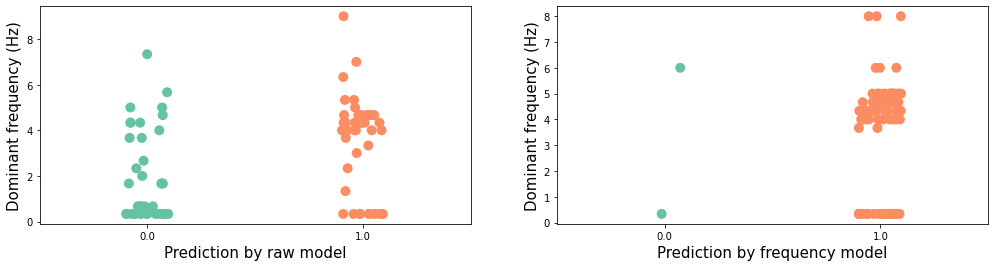

In [820]:
fig = plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
ax = sns.stripplot(x="RawPred", y="Raw", data=df3,size=10, palette="Set2")
ax.set_ylabel('Dominant frequency (Hz)',fontsize = 15)
ax.set_xlabel('Prediction by raw model',fontsize = 15)

plt.subplot(1,2,2)
ax = sns.stripplot(x="FreqPred", y="Freq",  data=df3, size=10, palette="Set2")
ax.set_ylabel('Dominant frequency (Hz)',fontsize = 15)
ax.set_xlabel('Prediction by frequency model',fontsize = 15)
plt.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/freqOverviewPara.png')

In [816]:
DomFFreqPara = np.squeeze(np.array(DomFFreqPara))

In [817]:
DomFRawPara = np.squeeze(np.array(DomFRawPara))

In [821]:
df3.iloc[0]

Freq        0.333333
FreqPred    1.000000
Raw         5.000000
RawPred     1.000000
Name: 0, dtype: float64

In [822]:
df3.iloc[9]

Freq        4.666667
FreqPred    1.000000
Raw         1.666667
RawPred     0.000000
Name: 9, dtype: float64